<a href="https://colab.research.google.com/github/hinaabbaskhan/snapchat-filters-mediapipe/blob/main/mediapipe_face_mesh_snapchat_filters_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Usage example of MediaPipe Face Mesh Solution API in Python (see also http://solutions.mediapipe.dev/face_mesh).

In [1]:
!pip install mediapipe


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [2]:
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np
import itertools
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

In [3]:
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)

In [4]:
import mediapipe as mp
mp_face_mesh = mp.solutions.face_mesh

help(mp_face_mesh.FaceMesh)

# Setup the face landmarks function for videos.
face_mesh_videos = mp_face_mesh.FaceMesh(
      static_image_mode=False,
      refine_landmarks=True,
      max_num_faces=1,
      min_detection_confidence=0.5,
      min_tracking_confidence=0.3)
# Setup MediaPipe Face Mesh for Images.
face_mesh_images= mp_face_mesh.FaceMesh(
       static_image_mode=True,
    refine_landmarks=True,
    max_num_faces=2,
    min_detection_confidence=0.5)

Help on class FaceMesh in module mediapipe.python.solutions.face_mesh:

class FaceMesh(mediapipe.python.solution_base.SolutionBase)
 |  FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
 |  
 |  MediaPipe Face Mesh.
 |  
 |  MediaPipe Face Mesh processes an RGB image and returns the face landmarks on
 |  each detected face.
 |  
 |  Please refer to https://solutions.mediapipe.dev/face_mesh#python-solution-api
 |  for usage examples.
 |  
 |  Method resolution order:
 |      FaceMesh
 |      mediapipe.python.solution_base.SolutionBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, static_image_mode=False, max_num_faces=1, refine_landmarks=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
 |      Initializes a MediaPipe Face Mesh object.
 |      
 |      Args:
 |        static_image_mode: Whether to treat the input images as a batch of static
 |          and

In [5]:
# Load drawing_utils and drawing_styles
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [6]:
def detectFacialLandmarks(image, face_mesh, display=True) :
    """
    Args:
      images:
      face_mesh:
      display:
    """

    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw face landmarks of each face.
    print(f'Face landmarks of {name}:')

    output_image = image.copy()

    if results.multi_face_landmarks:
      for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=output_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
            image=output_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image=output_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_iris_connections_style())

    if display :
      resize_and_show(image)
      resize_and_show(output_image)
    else:
      return np.ascontiguousarray(output_image), results

In [7]:
def getSize(image, face_landmarks, INDEXES):
    '''
    This function calculate the height and width of a face part utilizing its landmarks.
    Args:
        image:          The image of person(s) whose face part size is to be calculated.
        face_landmarks: The detected face landmarks of the person whose face part size is to
                        be calculated.
        INDEXES:        The indexes of the face part landmarks, whose size is to be calculated.
    Returns:
        width:     The calculated width of the face part of the face whose landmarks were passed.
        height:    The calculated height of the face part of the face whose landmarks were passed.
        landmarks: An array of landmarks of the face part whose size is calculated.
    '''

    # Retrieve the height and width of the image.
    image_height, image_width, _ = image.shape

    # Convert the indexes of the landmarks of the face part into a list.
    INDEXES_LIST = list(itertools.chain(*INDEXES))

    # Initialize a list to store the landmarks of the face part.
    landmarks = []

    # Iterate over the indexes of the landmarks of the face part.
    for INDEX in INDEXES_LIST:

        # Append the landmark into the list.
        landmarks.append([int(face_landmarks.landmark[INDEX].x * image_width),
                               int(face_landmarks.landmark[INDEX].y * image_height)])

    # Calculate the width and height of the face part.
    _, _, width, height = cv2.boundingRect(np.array(landmarks))

    # Convert the list of landmarks of the face part into a numpy array.
    landmarks = np.array(landmarks)

    # Retrurn the calculated width height and the landmarks of the face part.
    return width, height, landmarks

In [8]:
def isOpen(image, face_mesh_results, face_part, threshold=5, display=True):
    '''
    This function checks whether the an eye or mouth of the person(s) is open,
    utilizing its facial landmarks.
    Args:
        image:             The image of person(s) whose an eye or mouth is to be checked.
        face_mesh_results: The output of the facial landmarks detection on the image.
        face_part:         The name of the face part that is required to check.
        threshold:         The threshold value used to check the isOpen condition.
        display:           A boolean value that is if set to true the function displays
                           the output image and returns nothing.
    Returns:
        output_image: The image of the person with the face part is opened  or not status written.
        status:       A dictionary containing isOpen statuses of the face part of all the
                      detected faces.
    '''

    # Retrieve the height and width of the image.
    image_height, image_width, _ = image.shape

    # Create a copy of the input image to write the isOpen status.
    output_image = image.copy()

    # Create a dictionary to store the isOpen status of the face part of all the detected faces.
    status={}

    # Check if the face part is mouth.
    if face_part == 'MOUTH':

        # Get the indexes of the mouth.
        INDEXES = mp_face_mesh.FACEMESH_LIPS

        # Specify the location to write the is mouth open status.
        loc = (10, image_height - image_height//40)

        # Initialize a increment that will be added to the status writing location,
        # so that the statuses of two faces donot overlap.
        increment=-30

    # Check if the face part is left eye.
    elif face_part == 'LEFT EYE':

        # Get the indexes of the left eye.
        INDEXES = mp_face_mesh.FACEMESH_LEFT_EYE

        # Specify the location to write the is left eye open status.
        loc = (10, 30)

        # Initialize a increment that will be added to the status writing location,
        # so that the statuses of two faces donot overlap.
        increment=30

    # Check if the face part is right eye.
    elif face_part == 'RIGHT EYE':

        # Get the indexes of the right eye.
        INDEXES = mp_face_mesh.FACEMESH_RIGHT_EYE

        # Specify the location to write the is right eye open status.
        loc = (image_width-300, 30)

        # Initialize a increment that will be added to the status writing location,
        # so that the statuses of two faces donot overlap.
        increment=30

    # Otherwise return nothing.
    else:
        return

    # Iterate over the found faces.
    for face_no, face_landmarks in enumerate(face_mesh_results.multi_face_landmarks):

         # Get the height of the face part.
        _, height, _ = getSize(image, face_landmarks, INDEXES)

         # Get the height of the whole face.
        _, face_height, _ = getSize(image, face_landmarks, mp_face_mesh.FACEMESH_FACE_OVAL)

        # Check if the face part is open.
        if (height/face_height)*100 > threshold:

            # Set status of the face part to open.
            status[face_no] = 'OPEN'

            # Set color which will be used to write the status to green.
            color=(0,255,0)

        # Otherwise.
        else:
            # Set status of the face part to close.
            status[face_no] = 'CLOSE'

            # Set color which will be used to write the status to red.
            color=(0,0,255)

        # Write the face part isOpen status on the output image at the appropriate location.
        cv2.putText(output_image, f'FACE {face_no+1} {face_part} {status[face_no]}.',
                    (loc[0],loc[1]+(face_no*increment)), cv2.FONT_HERSHEY_PLAIN, 1.4, color, 2)

    # Check if the output image is specified to be displayed.
    if display:

        # Display the output image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');

    # Otherwise
    else:

        # Return the output image and the isOpen statuses of the face part of each detected face.
        return output_image, status

In [9]:
def overlay(image, filter_img, face_landmarks, face_part, INDEXES, display=True):
    '''
    This function will overlay a filter image over a face part of a person in the image/frame.
    Args:
        image:          The image of a person on which the filter image will be overlayed.
        filter_img:     The filter image that is needed to be overlayed on the image of the person.
        face_landmarks: The facial landmarks of the person in the image.
        face_part:      The name of the face part on which the filter image will be overlayed.
        INDEXES:        The indexes of landmarks of the face part.
        display:        A boolean value that is if set to true the function displays
                        the annotated image and returns nothing.
    Returns:
        annotated_image: The image with the overlayed filter on the top of the specified face part.
    '''

    # Create a copy of the image to overlay filter image on.
    annotated_image = image.copy()

    # Errors can come when it resizes the filter image to a too small or a too large size .
    # So use a try block to avoid application crashing.
    try:

        # Get the width and height of filter image.
        filter_img_height, filter_img_width, _  = filter_img.shape

        # Get the height of the face part on which we will overlay the filter image.
        _, face_part_height, landmarks = getSize(image, face_landmarks, INDEXES)

        # Specify the height to which the filter image is required to be resized.
        required_height = int(face_part_height*2.5)

        # Resize the filter image to the required height, while keeping the aspect ratio constant.
        resized_filter_img = cv2.resize(filter_img, (int(filter_img_width*
                                                         (required_height/filter_img_height)),
                                                     required_height))

        # Get the new width and height of filter image.
        filter_img_height, filter_img_width, _  = resized_filter_img.shape

        # Convert the image to grayscale and apply the threshold to get the mask image.
        _, filter_img_mask = cv2.threshold(cv2.cvtColor(resized_filter_img, cv2.COLOR_BGR2GRAY),
                                           25, 255, cv2.THRESH_BINARY_INV)

        # Calculate the center of the face part.
        center = landmarks.mean(axis=0).astype("int")

        # Check if the face part is mouth.
        if face_part == 'MOUTH':

            # Calculate the location where the smoke filter will be placed.
            # location = (int(center[0] - filter_img_width / 3), int(center[1]))
            # Calculate the location where the lips filter will be placed.
            location = (int(center[0] - filter_img_width / 2), int(center[1] - filter_img_height / 2))


        # Otherwise if the face part is an eye.
        else:

            # Calculate the location where the eye filter image will be placed.
            location = (int(center[0]-filter_img_width/2), int(center[1]-filter_img_height/2))

        # Retrieve the region of interest from the image where the filter image will be placed.
        ROI = image[location[1]: location[1] + filter_img_height,
                    location[0]: location[0] + filter_img_width]

        # Perform Bitwise-AND operation. This will set the pixel values of the region where,
        # filter image will be placed to zero.
        resultant_image = cv2.bitwise_and(ROI, ROI, mask=filter_img_mask)

        # Add the resultant image and the resized filter image.
        # This will update the pixel values of the resultant image at the indexes where
        # pixel values are zero, to the pixel values of the filter image.
        resultant_image = cv2.add(resultant_image, resized_filter_img)

        # Update the image's region of interest with resultant image.
        annotated_image[location[1]: location[1] + filter_img_height,
                        location[0]: location[0] + filter_img_width] = resultant_image

    # Catch and handle the error(s).
    except Exception as e:
        pass

    # Check if the annotated image is specified to be displayed.
    if display:

        # Display the annotated image.
        plt.figure(figsize=[10,10])
        plt.imshow(annotated_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');

    # Otherwise
    else:

        # Return the annotated image.
        return annotated_image

In [10]:
from google.colab import files
uploaded = files.upload()

Saving 2.jpg to 2.jpg


2.jpg


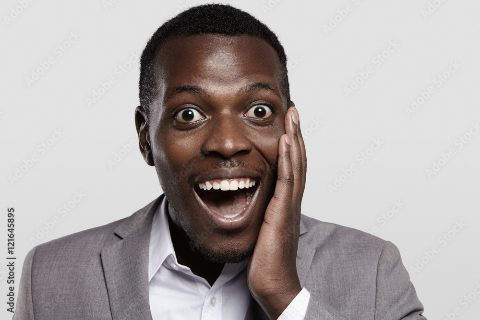

Face landmarks of 2.jpg:


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


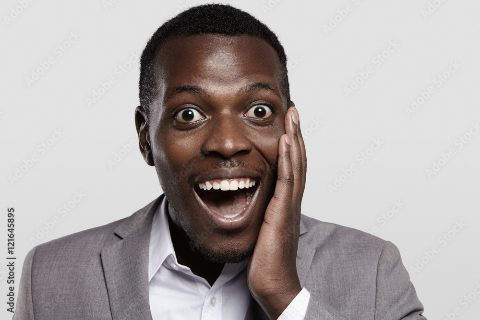

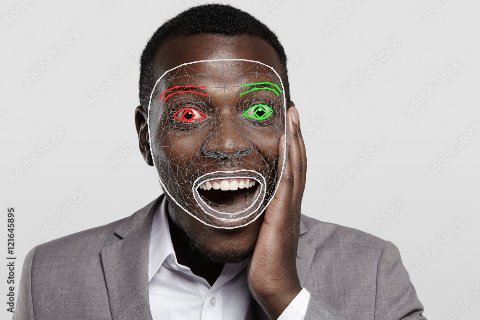

Face landmarks of 2.jpg:


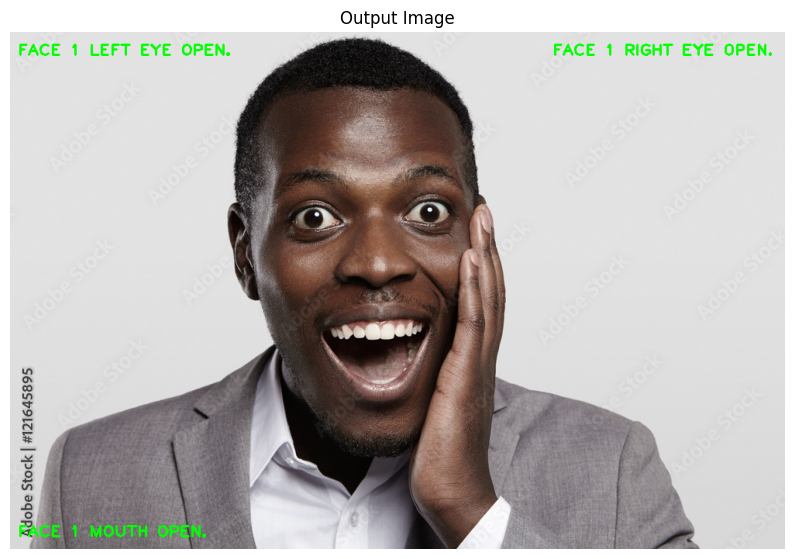

In [11]:
# Read images with OpenCV
images = {name: cv2.imread(name) for name in uploaded.keys()}

# Preview the images
for name, image in images.items():
    print(name)
    resize_and_show(image)
    detectFacialLandmarks(image, face_mesh_images, display=True)

    _, face_mesh_results = detectFacialLandmarks(image, face_mesh_images, display=False)

    if face_mesh_results.multi_face_landmarks:
        output_image, _ = isOpen(image, face_mesh_results, 'MOUTH', threshold=15, display=False)
        output_image, _ = isOpen(output_image, face_mesh_results, 'LEFT EYE', threshold=5, display=False)
        isOpen(output_image, face_mesh_results, 'RIGHT EYE', threshold=5)


In [12]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg
Face landmarks of Screenshot 2024-06-23 at 9.42.53 PM.png:


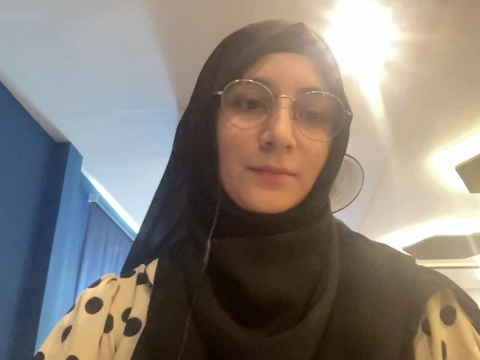

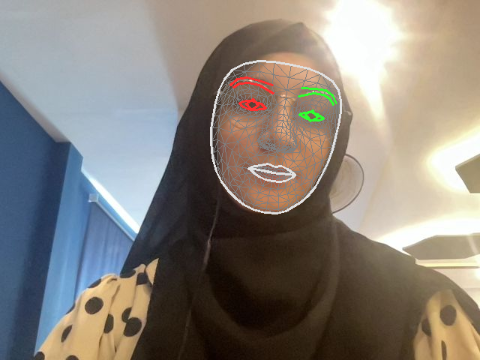

In [17]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  # display(Image(filename))
  capturedImage = cv2.imread(filename)
  detectFacialLandmarks(capturedImage, face_mesh_images, display=True)

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [13]:
from google.colab import files
uploaded = files.upload()


Saving blue.png to blue.png


<IPython.core.display.Javascript object>

Saved to photo.jpg
blue.png
Face landmarks of blue.png:


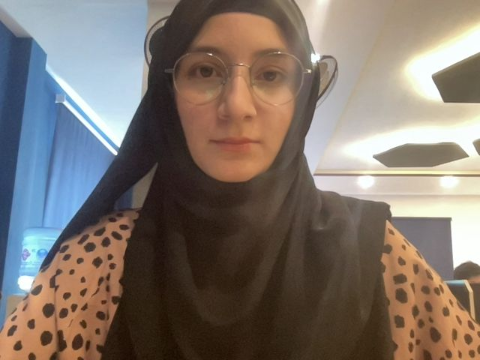

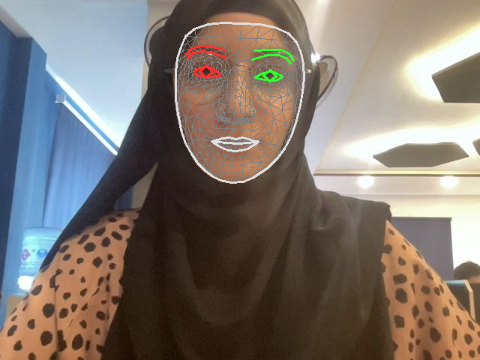

Face landmarks of blue.png:


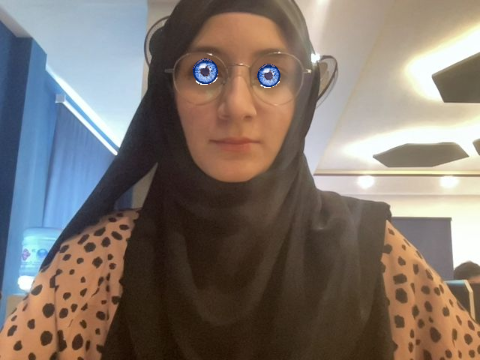

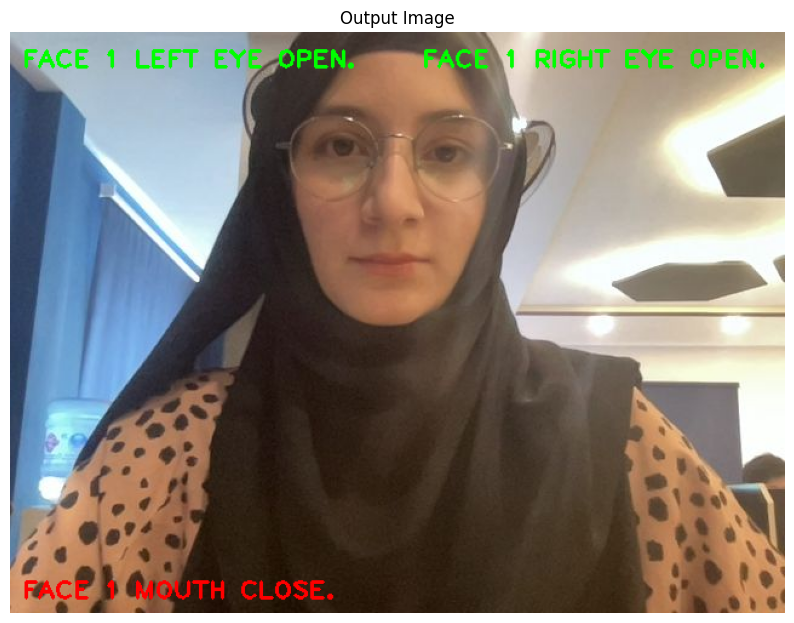

In [16]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Read the left and right eyes images.
  # left_eye = cv2.imread('media/eyes.png')
  # right_eye = cv2.imread('media/eyes.png')


  left_eyes = {name: cv2.imread(name) for name in uploaded.keys()}

# Preview the images
  for name, i in left_eyes.items():
      print(name)
      left_eye=i
      right_eye=i


  # Show the image which was just taken.
  # display(Image(filename))
  frame = cv2.imread(filename)


  # Perform Face landmarks detection and display it
  detectFacialLandmarks(frame, face_mesh_images, display=True)


  # Perform Face landmarks detection.
  _, face_mesh_results = detectFacialLandmarks(frame, face_mesh_images, display=False)

  # if face_mesh_results.multi_face_landmarks:
  output_image, _ = isOpen(frame, face_mesh_results, 'MOUTH', threshold=15, display=False)
  output_image, _ = isOpen(output_image, face_mesh_results, 'LEFT EYE', threshold=5, display=False)
  isOpen(output_image, face_mesh_results, 'RIGHT EYE', threshold=5)


  # Check if facial landmarks are found.
  if face_mesh_results.multi_face_landmarks:

      # Get the mouth isOpen status of the person in the frame.
      _, mouth_status = isOpen(frame, face_mesh_results, 'MOUTH',
                                    threshold=15, display=False)

      # Get the left eye isOpen status of the person in the frame.
      _, left_eye_status = isOpen(frame, face_mesh_results, 'LEFT EYE',
                                      threshold=4.5 , display=False)

      # Get the right eye isOpen status of the person in the frame.
      _, right_eye_status = isOpen(frame, face_mesh_results, 'RIGHT EYE',
                                        threshold=4.5, display=False)

      # Iterate over the found faces.
      for face_num, face_landmarks in enumerate(face_mesh_results.multi_face_landmarks):

          # Check if the left eye of the face is open.
          if left_eye_status[face_num] == 'OPEN':

              # Overlay the left eye image on the frame at the appropriate location.
              frame = overlay(frame, left_eye, face_landmarks,
                              'LEFT EYE', mp_face_mesh.FACEMESH_LEFT_EYE, display=False)


          # Check if the right eye of the face is open.
          if right_eye_status[face_num] == 'OPEN':

              # Overlay the right eye image on the frame at the appropriate location.
              frame = overlay(frame, right_eye, face_landmarks,
                              'RIGHT EYE', mp_face_mesh.FACEMESH_RIGHT_EYE, display=False)

    # Display the frame.
  resize_and_show(frame)


except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg
Face landmarks of 2.jpg:


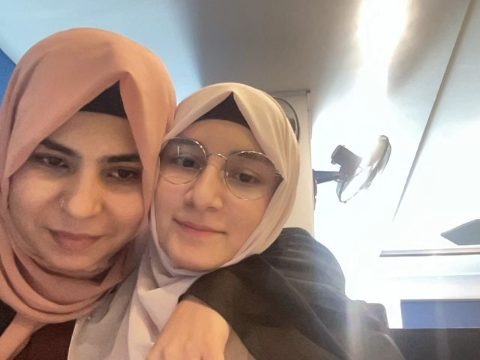

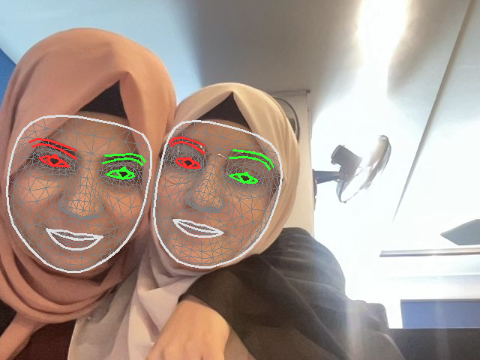

Face landmarks of 2.jpg:


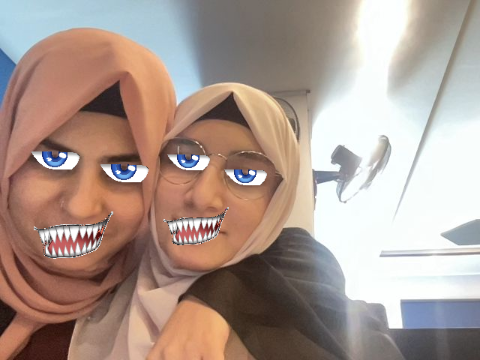

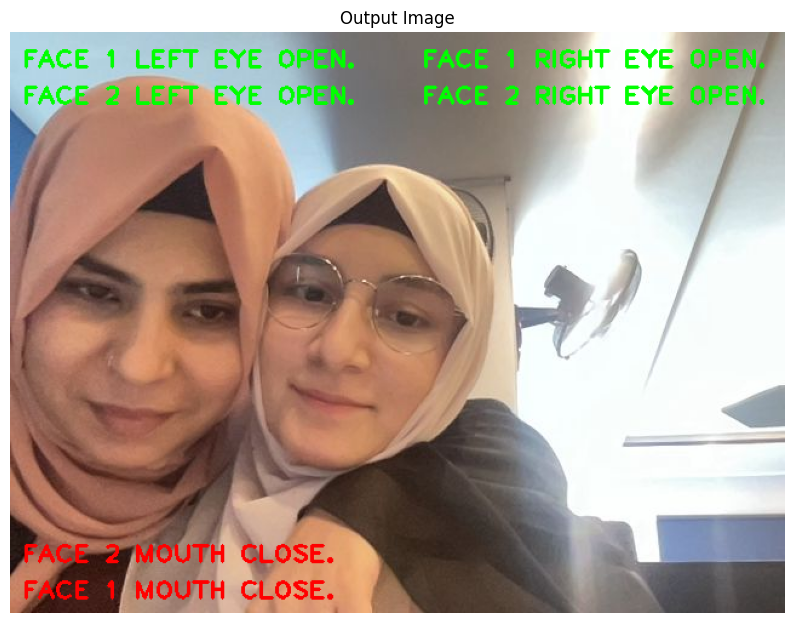

In [14]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Read the left and right eyes images.
  left_eye = cv2.imread('anime.png')
  right_eye = cv2.imread('anime.png')
  mouth = cv2.imread('mouth.png')


#   left_eyes = {name: cv2.imread(name) for name in uploaded.keys()}

# # Preview the images
#   for name, i in left_eyes.items():
#       print(name)
#       left_eye=i
#       right_eye=i


  # Show the image which was just taken.
  # display(Image(filename))
  frame = cv2.imread(filename)


  # Perform Face landmarks detection and display it
  detectFacialLandmarks(frame, face_mesh_images, display=True)


  # Perform Face landmarks detection.
  _, face_mesh_results = detectFacialLandmarks(frame, face_mesh_images, display=False)

  # if face_mesh_results.multi_face_landmarks:
  output_image, _ = isOpen(frame, face_mesh_results, 'MOUTH', threshold=15, display=False)
  output_image, _ = isOpen(output_image, face_mesh_results, 'LEFT EYE', threshold=5, display=False)
  isOpen(output_image, face_mesh_results, 'RIGHT EYE', threshold=5)


  # Check if facial landmarks are found.
  if face_mesh_results.multi_face_landmarks:

      # Get the mouth isOpen status of the person in the frame.
      _, mouth_status = isOpen(frame, face_mesh_results, 'MOUTH',
                                    threshold=15, display=False)

      # Get the left eye isOpen status of the person in the frame.
      _, left_eye_status = isOpen(frame, face_mesh_results, 'LEFT EYE',
                                      threshold=4.5 , display=False)

      # Get the right eye isOpen status of the person in the frame.
      _, right_eye_status = isOpen(frame, face_mesh_results, 'RIGHT EYE',
                                        threshold=4.5, display=False)

      # Iterate over the found faces.
      for face_num, face_landmarks in enumerate(face_mesh_results.multi_face_landmarks):

          # Check if the left eye of the face is open.
          if left_eye_status[face_num] == 'OPEN':

              # Overlay the left eye image on the frame at the appropriate location.
              frame = overlay(frame, left_eye, face_landmarks,
                              'LEFT EYE', mp_face_mesh.FACEMESH_LEFT_IRIS, display=False)


          # Check if the right eye of the face is open.
          if right_eye_status[face_num] == 'OPEN':

              # Overlay the right eye image on the frame at the appropriate location.
              frame = overlay(frame, right_eye, face_landmarks,
                              'RIGHT EYE', mp_face_mesh.FACEMESH_RIGHT_IRIS, display=False)

              # Overlay the smoke animation on the frame at the appropriate location.
              frame = overlay(frame, mouth, face_landmarks,
                                'MOUTH', mp_face_mesh.FACEMESH_LIPS, display=False)


    # Display the frame.
  resize_and_show(frame)


except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

************************************************************************

Upload any image that contains face(s) to the Colab. We take two example images from the web: https://unsplash.com/photos/JyVcAIUAcPM and https://unsplash.com/photos/auTAb39ImXg

sample (3).webp


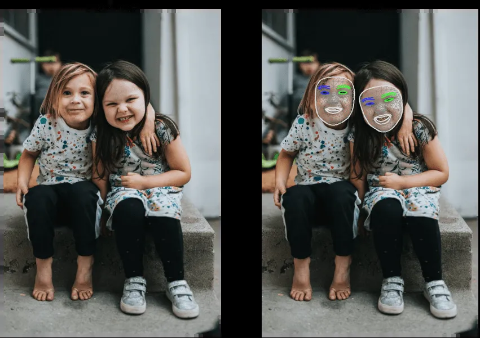

In [12]:
# Read images with OpenCV.
images = {name: cv2.imread(name) for name in uploaded.keys()}
# Preview the images.
for name, image in images.items():
  print(name)
  resize_and_show(image)

All MediaPipe Solutions Python API examples are under mp.solutions.

For the MediaPipe Face Mesh solution, we can access this module as `mp_face_mesh = mp.solutions.face_mesh`.

You may change the parameters, such as `static_image_mode`, `max_num_faces`, and `min_detection_confidence`, during the initialization. Run `help(mp_face_mesh.FaceMesh)` to get more informations about the parameters.

Screenshot 2024-06-23 at 9.42.53 PM (4).png
Face landmarks of Screenshot 2024-06-23 at 9.42.53 PM (4).png:


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


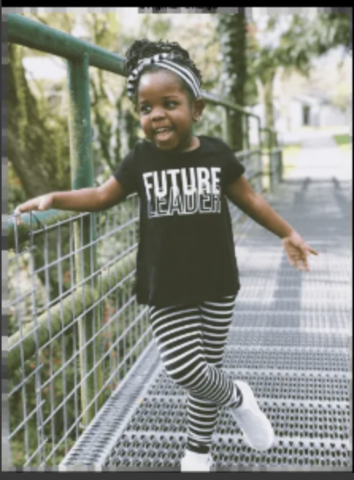

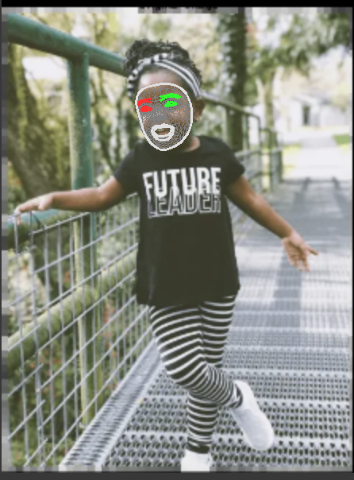

In [19]:
# Read images with OpenCV.
images = {name: cv2.imread(name) for name in uploaded.keys()}
# Preview the images.
for name, image in images.items():
  print(name)
  detectFacialLandmarks(image, face_mesh_images, display=True)

In [ ]:
  import cv2

  camera_video = cv2.VideoCapture()


  if not camera_video.isOpened():
    print("Error: Could not open camera.")
    exit()


  print("open camera.")

  camera_video.set(3,1280)
  camera_video.set(4,960)

  # Create named window for resizing purposes.
  cv2.namedWindow('Face Landmarks Detection', cv2.WINDOW_NORMAL)

  # Initialize a variable to store the time of the previous frame.
  time1 = 0

  # Iterate until the webcam is accessed successfully.
  while camera_video.isOpened():

      # Read a frame.
      ok, frame = camera_video.read()

      # Check if frame is not read properly then continue to the next iteration to
      # read the next frame.
      if not ok:
          continue

      # Flip the frame horizontally for natural (selfie-view) visualization.
      frame = cv2.flip(frame, 1)

      # Perform Face landmarks detection.
      frame, _ = detectFacialLandmarks(frame, face_mesh_videos, display=False)

      # Set the time for this frame to the current time.
      time2 = time()

      # Check if the difference between the previous and this frame time &gt; 0 to avoid
      # division by zero.
      if (time2 - time1) > 0:

          # Calculate the number of frames per second.
          frames_per_second = 1.0 / (time2 - time1)

          # Write the calculated number of frames per second on the frame.
          cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30),
                      cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)

      # Update the previous frame time to this frame time.
      # As this frame will become previous frame in next iteration.
      time1 = time2

      # Display the frame.
      cv2.imshow('Face Landmarks Detection', frame)

      # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
      k = cv2.waitKey(1) & 0xFF

      # Check if 'ESC' is pressed and break the loop.
      if(k == 27):
          break

  # Release the VideoCapture Object and close the windows.
  camera_video.release()
  cv2.destroyAllWindows()

In [12]:

uploaded = files.upload()


Saving Screenshot 2024-06-23 at 9.42.53 PM.png to Screenshot 2024-06-23 at 9.42.53 PM (8).png
